# Análise de dados de Heart Disease

Aluno: Ivon Luiz Correia Martinez Garcia
Professor: Antonio Carlos Lopes Fernandes Junior
Matéria: ENGG67

### Proposta
Utilizando o banco de dados “Heart Disease”:
(https://archive.ics.uci.edu/dataset/45/heart+disease) faça o que se pede a seguir.

* O conjunto de dados univariado ou multivariado? Descreva a quantidade de atributos
preditivos e atributos alvo.
* Caracterize os dados quanto ao Tipo e Escala;
* Verifique a necessidade de balanceamento dos dados e caracterize estatisticamente os dados (calcule, para cada atributo, suas estatísticas univariadas pertinentes dentre frequência, moda, média, mediana, desvio-padrão, Q1, Q3, obliquidade e curtose).
* Analise os dados quanto à sua incompletude, inconsistências, redundâncias e presença de ruído.
* Calcule estatísticas multivariadas de covariância e correlação para os atributos quantitativos presentes. Interprete os valores obtidos.
* Trace boxplots dos atributos preditivos e identifique a presença ou não de outliers.
* Plote histogramas dos atributos e interprete sua distribuição, considerando as classes.
* Promova uma transformação de dados consistente com o banco sob análise.
* Utilize a análise de componentes principais (PCA) para gerar gráficos no espaço de atributos.

### Bibliotecas

In [1]:
!pip install ucimlrepo


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
from scipy import stats
import seaborn as sns
import plotly.express as px

from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

### Obtendo dados

In [3]:
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 
print("Metadata\n")
print(heart_disease.metadata)

Metadata

{'uci_id': 45, 'name': 'Heart Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv', 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 303, 'num_features': 13, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['num'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C52P4X', 'creators': ['Andras Janosi', 'William Steinbrunn', 'Matthias Pfisterer', 'Robert Detrano'], 'intro_paper': {'ID': 231, 'type': 'NATIVE', 'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.', 'authors': 'R. Detrano, A. Jánosi, W. Ste

In [4]:
# data (as pandas dataframes) 
X = heart_disease.data.features 
y = heart_disease.data.targets 

In [5]:
X.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0
5,56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0
6,62,0,4,140,268,0,2,160,0,3.6,3,2.0,3.0
7,57,0,4,120,354,0,0,163,1,0.6,1,0.0,3.0
8,63,1,4,130,254,0,2,147,0,1.4,2,1.0,7.0
9,53,1,4,140,203,1,2,155,1,3.1,3,0.0,7.0


In [6]:
y.head()

,num
0,0
1,2
2,1
3,0
4,0


### a) Descrição dos atributos

O conjunto de dados é multivariado, já que contém múltiplas variáveis que podem ser analisadas simultaneamente.

In [7]:
print("Quantidade de atributos preditivos: " + str(len(X.columns)))

Quantidade de atributos preditivos: 13


In [8]:
print("Quantidade de atributos alvos: " + str(len(y.columns)))
print("Número de classes alvo: " + str(len(y['num'].unique())))

Quantidade de atributos alvos: 1
Número de classes alvo: 5


### b) Tipo e escala 

Vamos analisar os dados quanto ao seus tipos e escala.

In [9]:
print("Informações das variáveis\n") 
print(heart_disease.variables) 

Informações das variáveis

        name     role         type demographic  \
0        age  Feature      Integer         Age   
1        sex  Feature  Categorical         Sex   
2         cp  Feature  Categorical        None   
3   trestbps  Feature      Integer        None   
4       chol  Feature      Integer        None   
5        fbs  Feature  Categorical        None   
6    restecg  Feature  Categorical        None   
7    thalach  Feature      Integer        None   
8      exang  Feature  Categorical        None   
9    oldpeak  Feature      Integer        None   
10     slope  Feature  Categorical        None   
11        ca  Feature      Integer        None   
12      thal  Feature  Categorical        None   
13       num   Target      Integer        None   

                                          description  units missing_values  
0                                                None  years             no  
1                                                None   None      

In [10]:
X.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca          float64
thal        float64
dtype: object

Como todos os dados estão em int ou float, vamos separa-los adequadamente em quantitativas e categóricas, com base nos metadados.

In [11]:
quantitative_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

In [12]:
print("Valores únicos para colunas categóricas:")
for column in categorical_features:
    unique_values = X[column].unique()
    print(f"{column}: {unique_values}")

Valores únicos para colunas categóricas:
sex: [1 0]
cp: [1 4 3 2]
fbs: [1 0]
restecg: [2 0 1]
exang: [0 1]
slope: [3 2 1]
ca: [ 0.  3.  2.  1. nan]
thal: [ 6.  3.  7. nan]


As colunas categóricas realmente estão limitadas para inteiros que identificam cada categoria. Apesar de nos metadados anteriores, 'ca' ter vindo como numérico, escolhi transformá-lo para categórico também pelo fato dele se comportar como tal. Também temos alguns *nan* que serão lidados em breve.

In [13]:
X[categorical_features] = X[categorical_features].astype('category')

C:\Users\darth\AppData\Local\Temp\ipykernel_40808\4036185465.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[categorical_features] = X[categorical_features].astype('category')


Assim, podemos observar os data types corrigidos.

In [14]:
X.dtypes

age            int64
sex         category
cp          category
trestbps       int64
chol           int64
fbs         category
restecg     category
thalach        int64
exang       category
oldpeak      float64
slope       category
ca          category
thal        category
dtype: object

In [15]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       303 non-null    int64   
 1   sex       303 non-null    category
 2   cp        303 non-null    category
 3   trestbps  303 non-null    int64   
 4   chol      303 non-null    int64   
 5   fbs       303 non-null    category
 6   restecg   303 non-null    category
 7   thalach   303 non-null    int64   
 8   exang     303 non-null    category
 9   oldpeak   303 non-null    float64 
 10  slope     303 non-null    category
 11  ca        299 non-null    category
 12  thal      301 non-null    category
dtypes: category(8), float64(1), int64(4)
memory usage: 15.5 KB


Podemos ver que as colunas 'ca' e 'thal' estão com alguns dados faltando. Vamos lidar com isso em breve.

### c) Análises estatísticas

Para verificar o balanceamento, vamos olhar a distribuição da variável alvo (por exemplo, target). Se a variável alvo não estiver balanceada, isso pode indicar a necessidade de balanceamento.

In [16]:
print("Contagem de cada classe da variável alvo:")
print(y.value_counts())
print("Distribuição da variável alvo:")
print(y.value_counts(normalize=True))

Contagem de cada classe da variável alvo:
num
0      164
1       55
2       36
3       35
4       13
Name: count, dtype: int64
Distribuição da variável alvo:
num
0      0.541254
1      0.181518
2      0.118812
3      0.115512
4      0.042904
Name: proportion, dtype: float64


Os dados se apresentam desbalanceados.

* Classe 0: Representa aproximadamente 54% dos dados, o que indica que é a classe majoritária.
* Classe 1: Representa cerca de 18% dos dados.
* Classes 2 e 3: Cada uma representa aproximadamente 11-12% dos dados.
* Classe 4: É a mais rara, com apenas 4% dos dados.

Esse desbalanceamento pode impactar modelos preditivos, pois eles tendem a favorecer a classe majoritária. Para mitigar este efeito, podemos aplicar técnicas de balanceamento, como:

* Oversampling: Replicar amostras das classes minoritárias para aumentar sua representação.
* Undersampling: Reduzir amostras da classe majoritária para equilibrar o conjunto de dados.
* Algoritmos de amostragem sintética: Como o SMOTE (Synthetic Minority Over-sampling Technique), que gera amostras sintéticas para as classes minoritárias.

Vamos agora calcular as estatísticas descritivas pertinentes para cada coluna. Para as colunas categóricas, faremos uma contagem de frequência e a moda, enquanto para as colunas numéricas calcularemos média, mediana, desvio-padrão, quartis (Q1 e Q3), obliquidade (assimetria) e curtose.

In [17]:
print("Estatísticas univariadas para colunas categóricas:")

for column in categorical_features:
    data = X[column]
    
    print(f"\nColuna: {column}")
    print(f"Frequência dos valores:")
    print(data.value_counts())
    print(f"Moda: {data.mode()[0]}")

Estatísticas univariadas para colunas categóricas:

Coluna: sex
Frequência dos valores:
sex
1    206
0     97
Name: count, dtype: int64
Moda: 1

Coluna: cp
Frequência dos valores:
cp
4    144
3     86
2     50
1     23
Name: count, dtype: int64
Moda: 4

Coluna: fbs
Frequência dos valores:
fbs
0    258
1     45
Name: count, dtype: int64
Moda: 0

Coluna: restecg
Frequência dos valores:
restecg
0    151
2    148
1      4
Name: count, dtype: int64
Moda: 0

Coluna: exang
Frequência dos valores:
exang
0    204
1     99
Name: count, dtype: int64
Moda: 0

Coluna: slope
Frequência dos valores:
slope
1    142
2    140
3     21
Name: count, dtype: int64
Moda: 1

Coluna: ca
Frequência dos valores:
ca
0.0    176
1.0     65
2.0     38
3.0     20
Name: count, dtype: int64
Moda: 0.0

Coluna: thal
Frequência dos valores:
thal
3.0    166
7.0    117
6.0     18
Name: count, dtype: int64
Moda: 3.0



- **sex (Gênero):**

  * 1 (Masculino): 206
  * 0 (Feminino): 97
  * Moda: 1 (Masculino) – A maioria da amostra é composta por indivíduos do sexo masculino, o que pode indicar um viés no conjunto de dados.

- **cp (Tipo de dor torácica)**

  * 4 (Angina típica): 144
  * 3 (Angina atípica): 86
  * 2 (Dor não anginosa): 50
  * 1 (Sem dor): 23
  * Moda: 4 (Angina típica) – O tipo mais frequente de dor torácica relatada na amostra é a angina típica, indicando que muitos pacientes podem apresentar sintomas mais graves.

- **fbs (Nível de açúcar no sangue em jejum)**

  * 0 (Menos de 120 mg/dL): 258
  * 1 (120 mg/dL ou mais): 45
  * Moda: 0 – A maioria dos indivíduos tem níveis de açúcar no sangue em jejum abaixo de 120 mg/dL, o que pode ser um indicador de boa saúde metabólica para a maioria da amostra.

- **restecg (Resultados do eletrocardiograma em repouso)**

  * 0 (Normal): 151
  * 2 (Anormalidade leve): 148
  * 1 (Anormalidade significativa): 4
  * Moda: 0 (Normal) – A maioria dos indivíduos apresenta resultados normais no eletrocardiograma em repouso, com um número relativamente baixo de anormalidades significativas.


- **exang (Angina induzida por exercício)**

  * 0 (Não): 204
  * 1 (Sim): 99
  * Moda: 0 (Não) – A maioria dos indivíduos não apresenta angina induzida por exercício, o que pode sugerir uma boa condição cardiovascular na maior parte da amostra.

- **slope (Inclinação do segmento ST)**

  * 1 (Descendente): 142
  * 2 (Horizontal): 140
  * 3 (Ascendente): 21
  * Moda: 1 (Descendente) – A inclinação descendente é a mais comum, o que pode ter implicações para a avaliação da saúde cardiovascular.

- **ca (Número de vasos sanguíneos principais)**
  
  * 0: 176
  * 1: 69
  * 2: 38
  * 3: 20
  * Moda: 0 – A maioria dos indivíduos não apresenta vasos sanguíneos principais destacados, indicando menos probabilidade de doença arterial coronariana severa.

- **thal (Talassemia)**
  
  * 3.0 (Normal): 166
  * 7.0 (Defeito reversível): 117
  * 6.0 (Defeito irreversível): 20
  * Moda: 3.0 (Normal) – A condição normal é a mais frequente, indicando que a maioria dos indivíduos não apresenta defeitos relacionados à talassemia.

In [18]:
print("Estatísticas univariadas para colunas numéricas:")

for column in quantitative_features:
    data = X[column]
    
    print(f"\nColuna: {column}")
    print(f"  Média: {round(data.mean(), 2)}")
    print(f"  Mediana: {data.median()}")
    print(f"  Moda: {data.mode()[0]}")
    print(f"  Desvio-padrão: {round(data.std(), 2)}")
    print(f"  Q1 (1º Quartil): {data.quantile(0.25)}")
    print(f"  Q3 (3º Quartil): {data.quantile(0.75)}")
    print(f"  Obliquidade (Assimetria): {round(stats.skew(data), 2)}")
    print(f"  Curtose: {round(stats.kurtosis(data), 2)}")

Estatísticas univariadas para colunas numéricas:

Coluna: age
  Média: 54.44
  Mediana: 56.0
  Moda: 58
  Desvio-padrão: 9.04
  Q1 (1º Quartil): 48.0
  Q3 (3º Quartil): 61.0
  Obliquidade (Assimetria): -0.21
  Curtose: -0.53

Coluna: trestbps
  Média: 131.69
  Mediana: 130.0
  Moda: 120
  Desvio-padrão: 17.6
  Q1 (1º Quartil): 120.0
  Q3 (3º Quartil): 140.0
  Obliquidade (Assimetria): 0.7
  Curtose: 0.85

Coluna: chol
  Média: 246.69
  Mediana: 241.0
  Moda: 197
  Desvio-padrão: 51.78
  Q1 (1º Quartil): 211.0
  Q3 (3º Quartil): 275.0
  Obliquidade (Assimetria): 1.13
  Curtose: 4.4

Coluna: thalach
  Média: 149.61
  Mediana: 153.0
  Moda: 162
  Desvio-padrão: 22.88
  Q1 (1º Quartil): 133.5
  Q3 (3º Quartil): 166.0
  Obliquidade (Assimetria): -0.53
  Curtose: -0.07

Coluna: oldpeak
  Média: 1.04
  Mediana: 0.8
  Moda: 0.0
  Desvio-padrão: 1.16
  Q1 (1º Quartil): 0.0
  Q3 (3º Quartil): 1.6
  Obliquidade (Assimetria): 1.26
  Curtose: 1.53


Temos portanto, indivíduos mais velhos no nosso dataset. 
Observamos que temos indivíduos com pressão mais altas que o normal.
Podemos identificar também que existem outliers nos dados de colesterol.

### d) Análises com base em incompletude, inconsistências, redundâncias e presença de ruído.

#### *Incompletude*:
Lidar com valores faltantes.

In [19]:
missing_values = X.isnull().sum()
print("Valores ausentes por coluna:")
print(missing_values)

Valores ausentes por coluna:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
dtype: int64


In [20]:
X[X.isnull().any(axis=1)]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
87,53,0,3,128,216,0,2,115,0,0.0,1,0.0,NaN
166,52,1,3,138,223,0,0,169,0,0.0,1,NaN,3.0
192,43,1,4,132,247,1,2,143,1,0.1,2,NaN,7.0
266,52,1,4,128,204,1,0,156,1,1.0,2,0.0,NaN
287,58,1,2,125,220,0,0,144,0,0.4,2,NaN,7.0
302,38,1,3,138,175,0,0,173,0,0.0,1,NaN,3.0


Quando os valores ausentes são de colunas categóricas (string ou numéricas), os valores ausentes podem ser substituídos pela categoria mais frequente. Se o número de valores ausentes for muito grande, ele poderá ser substituído por uma nova categoria, que não é nosso caso.

Porém, um algoritmo K-Nearest Neighbors (KNN) pode ser vantajoso pois ele identifica os k vizinhos mais próximos de uma instância com valor ausente e imputa um valor com base nos valores mais frequentes (moda) desses vizinhos.

Algumas vantagens do KNN a outras técnicas é que ele não é um método tão simples quanto moda, média e mediana. Ele não assume relação linear entre as variáveis como uma regressão e é menos sensível a outliers.

In [21]:
def knn_sub_null_values(data, columns, categorical=False, neighbors=5):
    df = data.copy()
    missing_info = {}
    
    for column in columns:
        missing_idx = df[df[column].isnull()].index
        
        if len(missing_idx) > 0:
            # Define o número de vizinhos com base no número de categorias únicas
            unique_values = df[column].dropna().unique()
            imputer = KNNImputer(n_neighbors=neighbors)
            df[[column]] = imputer.fit_transform(df[[column]])
            
            # Arredonda os valores para o inteiro mais próximo, já que são categorias
            if categorical == True:
                df[column] = df[column].round().astype(int)
            
                # Garante que os valores imputados estão nas categorias originais
                df[column] = df[column].apply(lambda x: x if x in unique_values else unique_values[0])
            
            missing_info[column] = list(missing_idx)
    
    for col, idx in missing_info.items():
        print(f"Valores ausentes na coluna '{col}' foram substituídos nas linhas: {idx}")
    
    return df

In [22]:
X = knn_sub_null_values(X, ['ca', 'thal'], categorical=True)

Valores ausentes na coluna 'ca' foram substituídos nas linhas: [166, 192, 287, 302]
Valores ausentes na coluna 'thal' foram substituídos nas linhas: [87, 266]


In [23]:
X.iloc[[87, 166, 192, 266, 287, 302]]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
87,53,0,3,128,216,0,2,115,0,0.0,1,0,6.0
166,52,1,3,138,223,0,0,169,0,0.0,1,1,3.0
192,43,1,4,132,247,1,2,143,1,0.1,2,1,7.0
266,52,1,4,128,204,1,0,156,1,1.0,2,0,6.0
287,58,1,2,125,220,0,0,144,0,0.4,2,1,7.0
302,38,1,3,138,175,0,0,173,0,0.0,1,1,3.0


Podemos ver que substituímos os valores em branco dessas colunas por categorias razoáveis.

#### *Inconsistências*:
Vamos verificar limites razoáveis para variáveis numéricas

In [24]:
for col in categorical_features:
    unique_values = X[col].unique()
    print(f"Valores únicos de {col}: {unique_values}")

print()

for col in quantitative_features:
    print(f"{col} - Min: {X[col].min()}, Max: {X[col].max()}")

Valores únicos de sex: [1, 0]
Categories (2, int64): [0, 1]
Valores únicos de cp: [1, 4, 3, 2]
Categories (4, int64): [1, 2, 3, 4]
Valores únicos de fbs: [1, 0]
Categories (2, int64): [0, 1]
Valores únicos de restecg: [2, 0, 1]
Categories (3, int64): [0, 1, 2]
Valores únicos de exang: [0, 1]
Categories (2, int64): [0, 1]
Valores únicos de slope: [3, 2, 1]
Categories (3, int64): [1, 2, 3]
Valores únicos de ca: [0 3 2 1]
Valores únicos de thal: [6. 3. 7.]

age - Min: 29, Max: 77
trestbps - Min: 94, Max: 200
chol - Min: 126, Max: 564
thalach - Min: 71, Max: 202
oldpeak - Min: 0.0, Max: 6.2


#### *Redundâncias:*

Observemos se existe linhas duplicatas

In [25]:
duplicate_rows = X.duplicated().sum()
print(f"Linhas duplicadas: {duplicate_rows}")

Linhas duplicadas: 0


#### *Presença de ruído:*

O noisy data pode ser causado por uma variedade de fatores. Um dos principais motivos é a coleta inadequada de dados. Erros humanos, falhas nos sistemas de coleta e problemas durante a transmissão dos dados podem introduzir ruído nos conjuntos de dados. Além disso, a falta de padronização nos formatos e nas estruturas dos dados também pode contribuir para a presença de dados ruidosos.

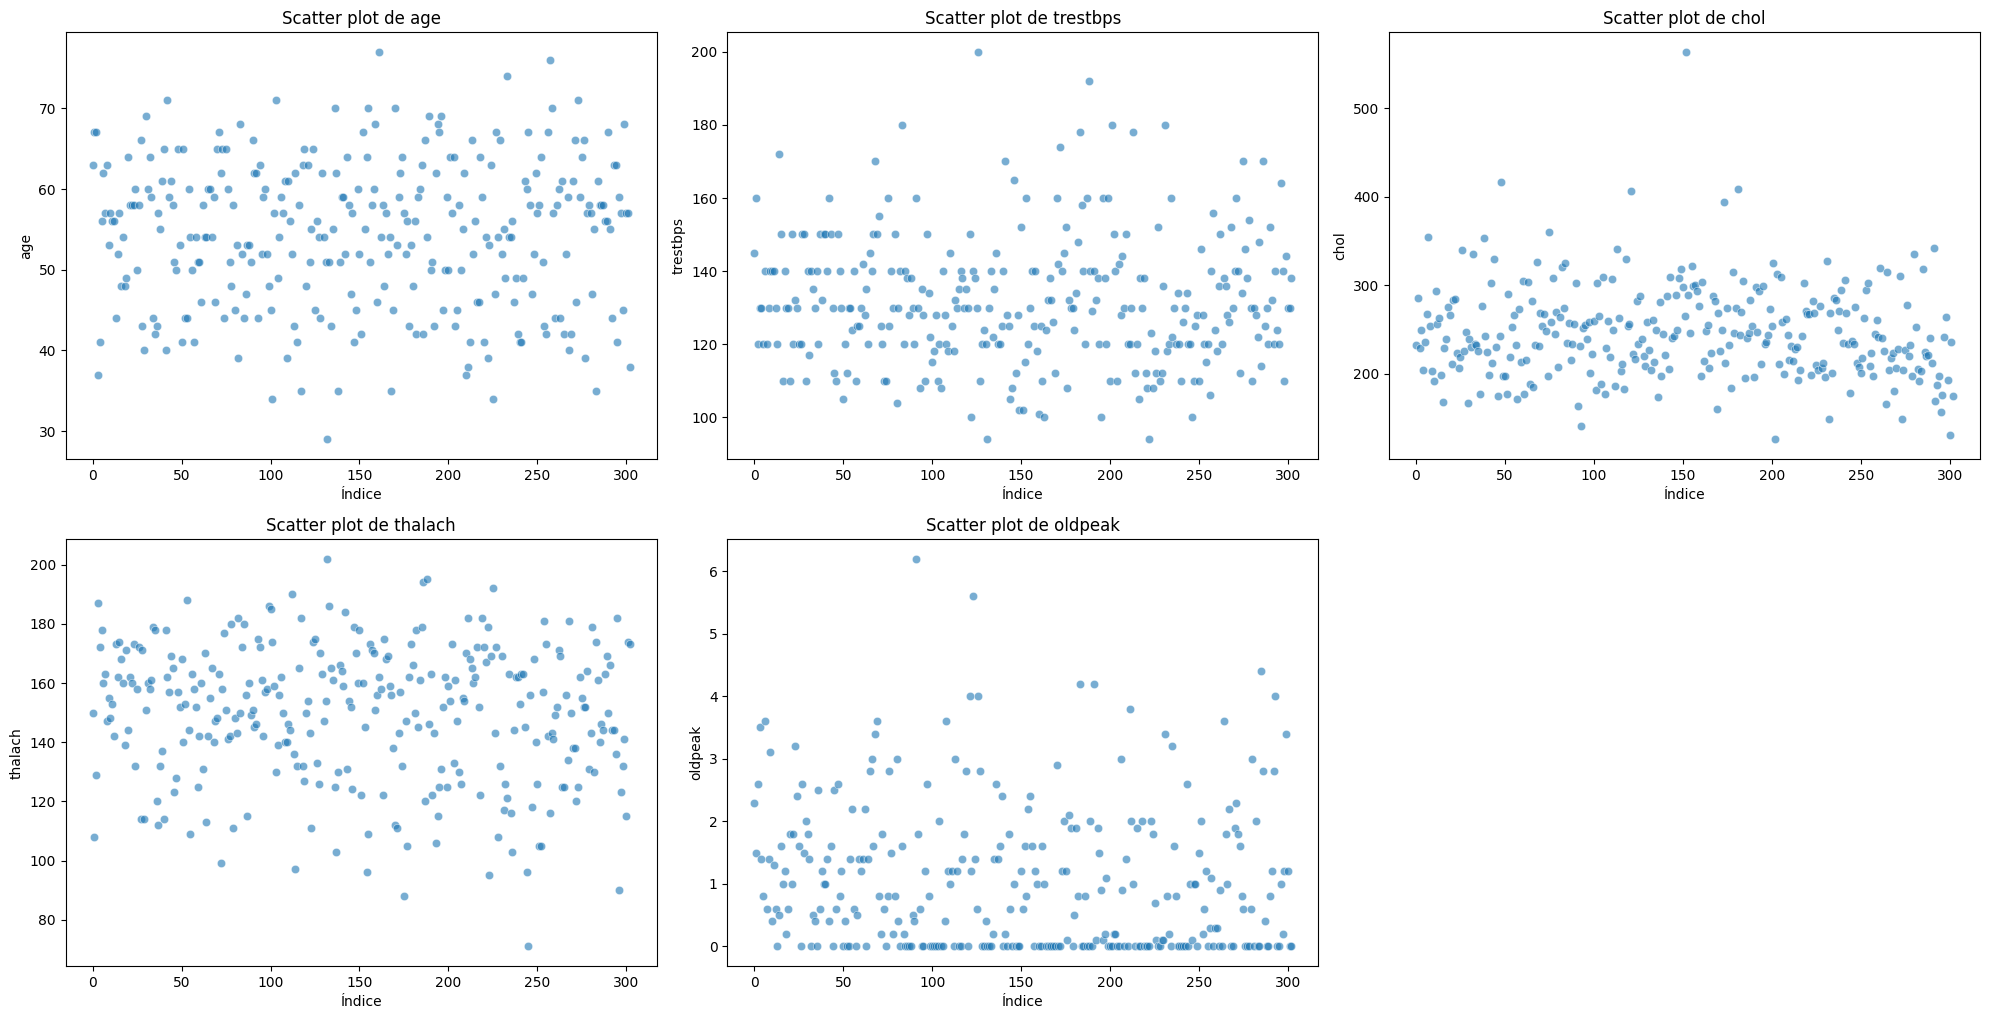

In [26]:
plt.figure(figsize=(20, 20))

for i, column in enumerate(quantitative_features, 1):
    plt.subplot(4, 3, i)  # Ajuste o grid conforme o número de variáveis
    sns.scatterplot(x=X.index, y=X[column], alpha=0.6)
    plt.title(f'Scatter plot de {column}')
    plt.xlabel('Índice')
    plt.ylabel(column)

plt.tight_layout()
plt.show()

### e) Matrizes de covariância e correlação

**Covariância**: Valores positivos indicam que, em média, as variáveis aumentam ou diminuem juntas, enquanto valores negativos indicam que uma variável tende a diminuir quando a outra aumenta. Valores próximos de zero indicam pouca ou nenhuma variação conjunta.

**Correlação**: Valores próximos de 1 indicam uma forte correlação positiva (ambas variáveis aumentam juntas). Valores próximos de -1 indicam uma forte correlação negativa (uma variável aumenta enquanto a outra diminui). Valores próximos de 0 indicam pouca ou nenhuma correlação linear.

In [27]:
cov_matrix = X[quantitative_features].cov()
print("Matriz de covariância:\n", cov_matrix)

Matriz de covariância:
                 age    trestbps         chol     thalach   oldpeak
age       81.697419   45.328678    97.787489  -81.423065  2.138850
trestbps  45.328678  309.751120   118.573339  -18.258005  3.865638
chol      97.787489  118.573339  2680.849190   -4.064651  2.799282
thalach  -81.423065  -18.258005    -4.064651  523.265775 -9.112209
oldpeak    2.138850    3.865638     2.799282   -9.112209  1.348095


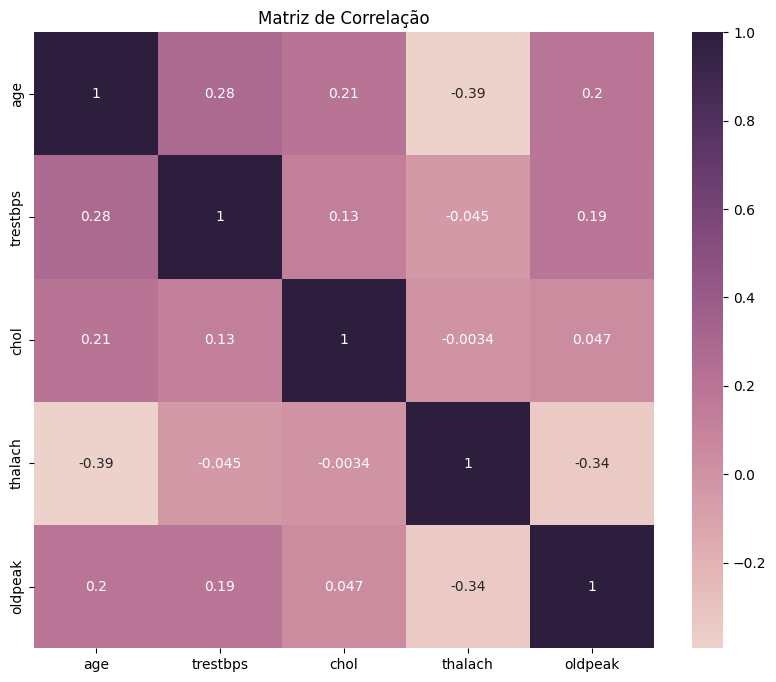

In [28]:
cov_matrix = X[quantitative_features].cov()
corr_matrix = X[quantitative_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap=sns.cubehelix_palette(as_cmap=True))
plt.title("Matriz de Correlação")
plt.show()


* Age e Thalach: A correlação negativa de -0.39 mostra uma relação inversa moderada entre idade e frequência cardíaca máxima, indicando que pessoas mais velhas tendem a ter frequências cardíacas máximas mais baixas.
* Age e Trestbps: A correlação de 0.28 sugere uma relação positiva fraca entre idade e pressão arterial em repouso.
* Oldpeak e Thalach: Com uma correlação de -0.34, isso indica que indivíduos com maior frequência cardíaca tendem a ter valores menores de oldpeak, o que é consistente com o aumento da recuperação cardíaca com maior frequência cardíaca.
* Trestbps e Chol: Com uma correlação de 0.13, a relação é positiva, mas muito fraca, sugerindo que pressão arterial em repouso e colesterol têm pouca dependência.

### f) Boxplots

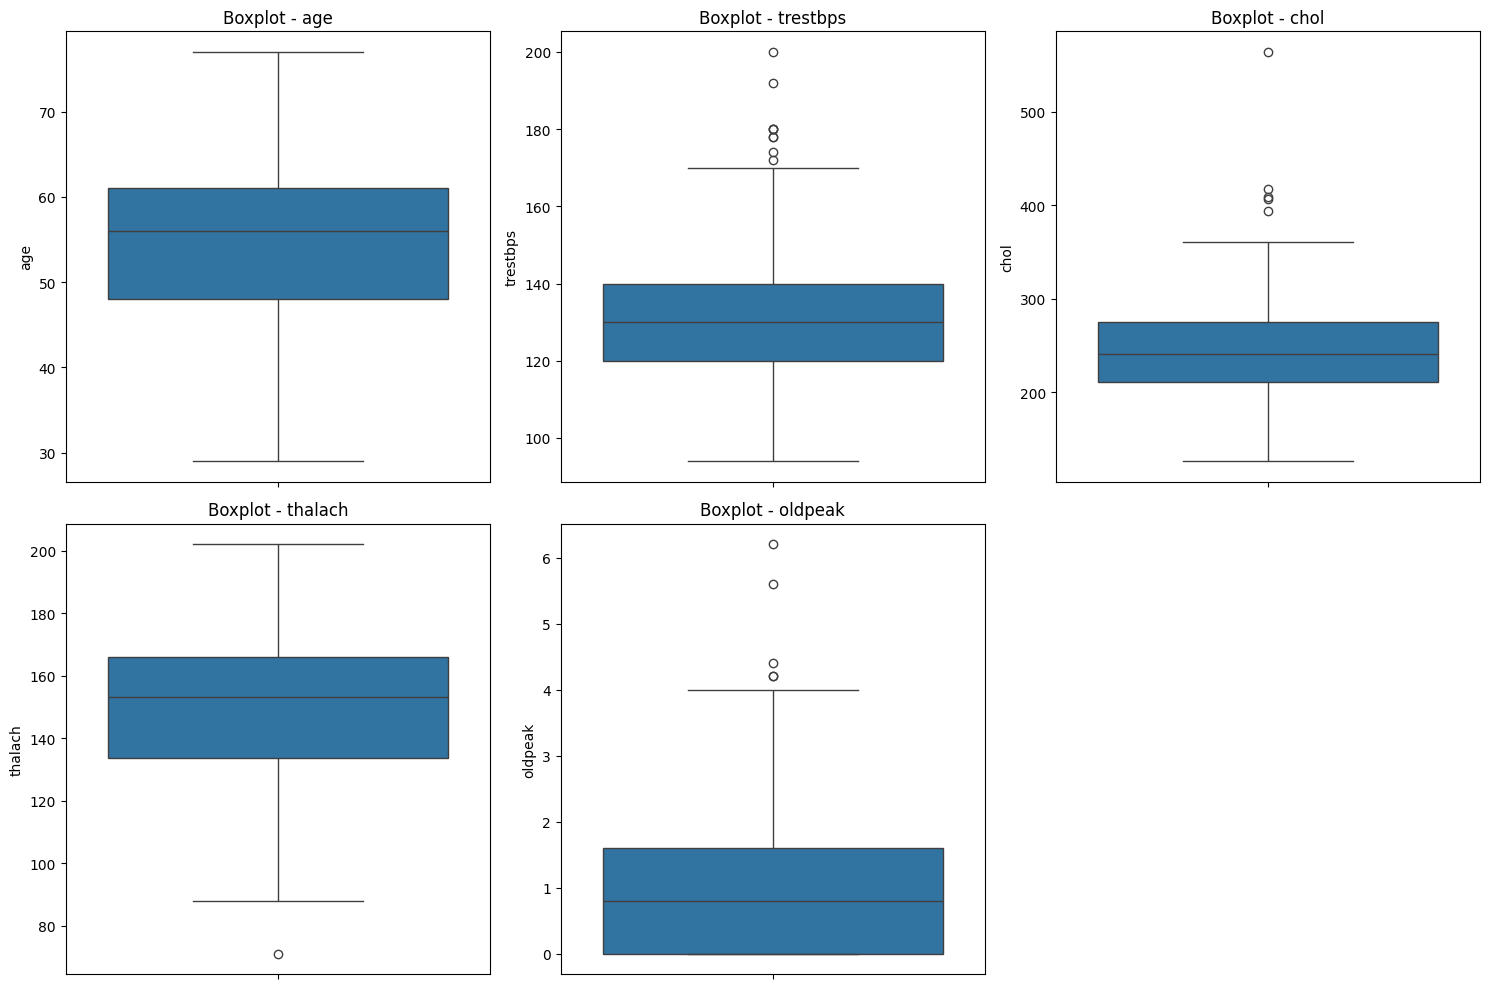

In [29]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(quantitative_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=X[col])
    plt.title(f'Boxplot - {col}')
plt.tight_layout()
plt.show()

Agora para identificar o valor de cada um, podemos calcular o intervalo interquartil (IQR) para cada coluna. Ele é a diferença entre o terceiro quartil e o primeiro.

Definimos os limites e por fim printamos os outliers que estão acima ou abaixo dos intervalos

In [30]:
outliers = {}

for col in quantitative_features:
    Q1 = X[col].quantile(0.25)
    Q3 = X[col].quantile(0.75)
    IQR = Q3 - Q1
    
    # Definir limites
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identificar outliers
    outliers[col] = X[(X[col] < lower_bound) | (X[col] > upper_bound)][col]
    
    # Exibir resumo de outliers
    print(f"Outliers em {col}:")
    print(outliers[col])
    print(f"Total de outliers em {col}: {len(outliers[col])}\n")

Outliers em age:
Series([], Name: age, dtype: int64)
Total de outliers em age: 0

Outliers em trestbps:
14     172
83     180
126    200
172    174
183    178
188    192
201    180
213    178
231    180
Name: trestbps, dtype: int64
Total de outliers em trestbps: 9

Outliers em chol:
48     417
121    407
152    564
173    394
181    409
Name: chol, dtype: int64
Total de outliers em chol: 5

Outliers em thalach:
245    71
Name: thalach, dtype: int64
Total de outliers em thalach: 1

Outliers em oldpeak:
91     6.2
123    5.6
183    4.2
191    4.2
285    4.4
Name: oldpeak, dtype: float64
Total de outliers em oldpeak: 5



* age: Não foram encontrados outliers para essa variável.
* trestbps (pressão arterial em repouso): Identificamos 9 outliers. Esses valores são significativamente maiores que os demais no dataset, indicando valores de pressão arterial muito elevados.
* chol (colesterol sérico): Foram encontrados 5 outliers, que são valores muito altos de colesterol sérico. Esses valores podem ser casos extremos de níveis de colesterol, o que pode ser normal em uma população de pacientes com histórico de doenças cardíacas.
* thalach (frequência cardíaca máxima): Apenas 1 outlier foi identificado, representando uma frequência cardíaca muito baixa em comparação com o restante dos dados.
* oldpeak (depressão do segmento ST induzida pelo exercício): Encontramos 5 outliers, todos valores muito altos, o que pode indicar casos graves de alteração do segmento ST.

### g) Histograma

In [31]:
X_y = pd.concat([X, y], axis=1)
X_y.rename(columns={'num': 'y'}, inplace=True)
X_y

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,y
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45,1,1,110,264,0,0,132,0,1.2,2,0,7.0,1
299,68,1,4,144,193,1,0,141,0,3.4,2,2,7.0,2
300,57,1,4,130,131,0,0,115,1,1.2,2,1,7.0,3
301,57,0,2,130,236,0,2,174,0,0.0,2,1,3.0,1


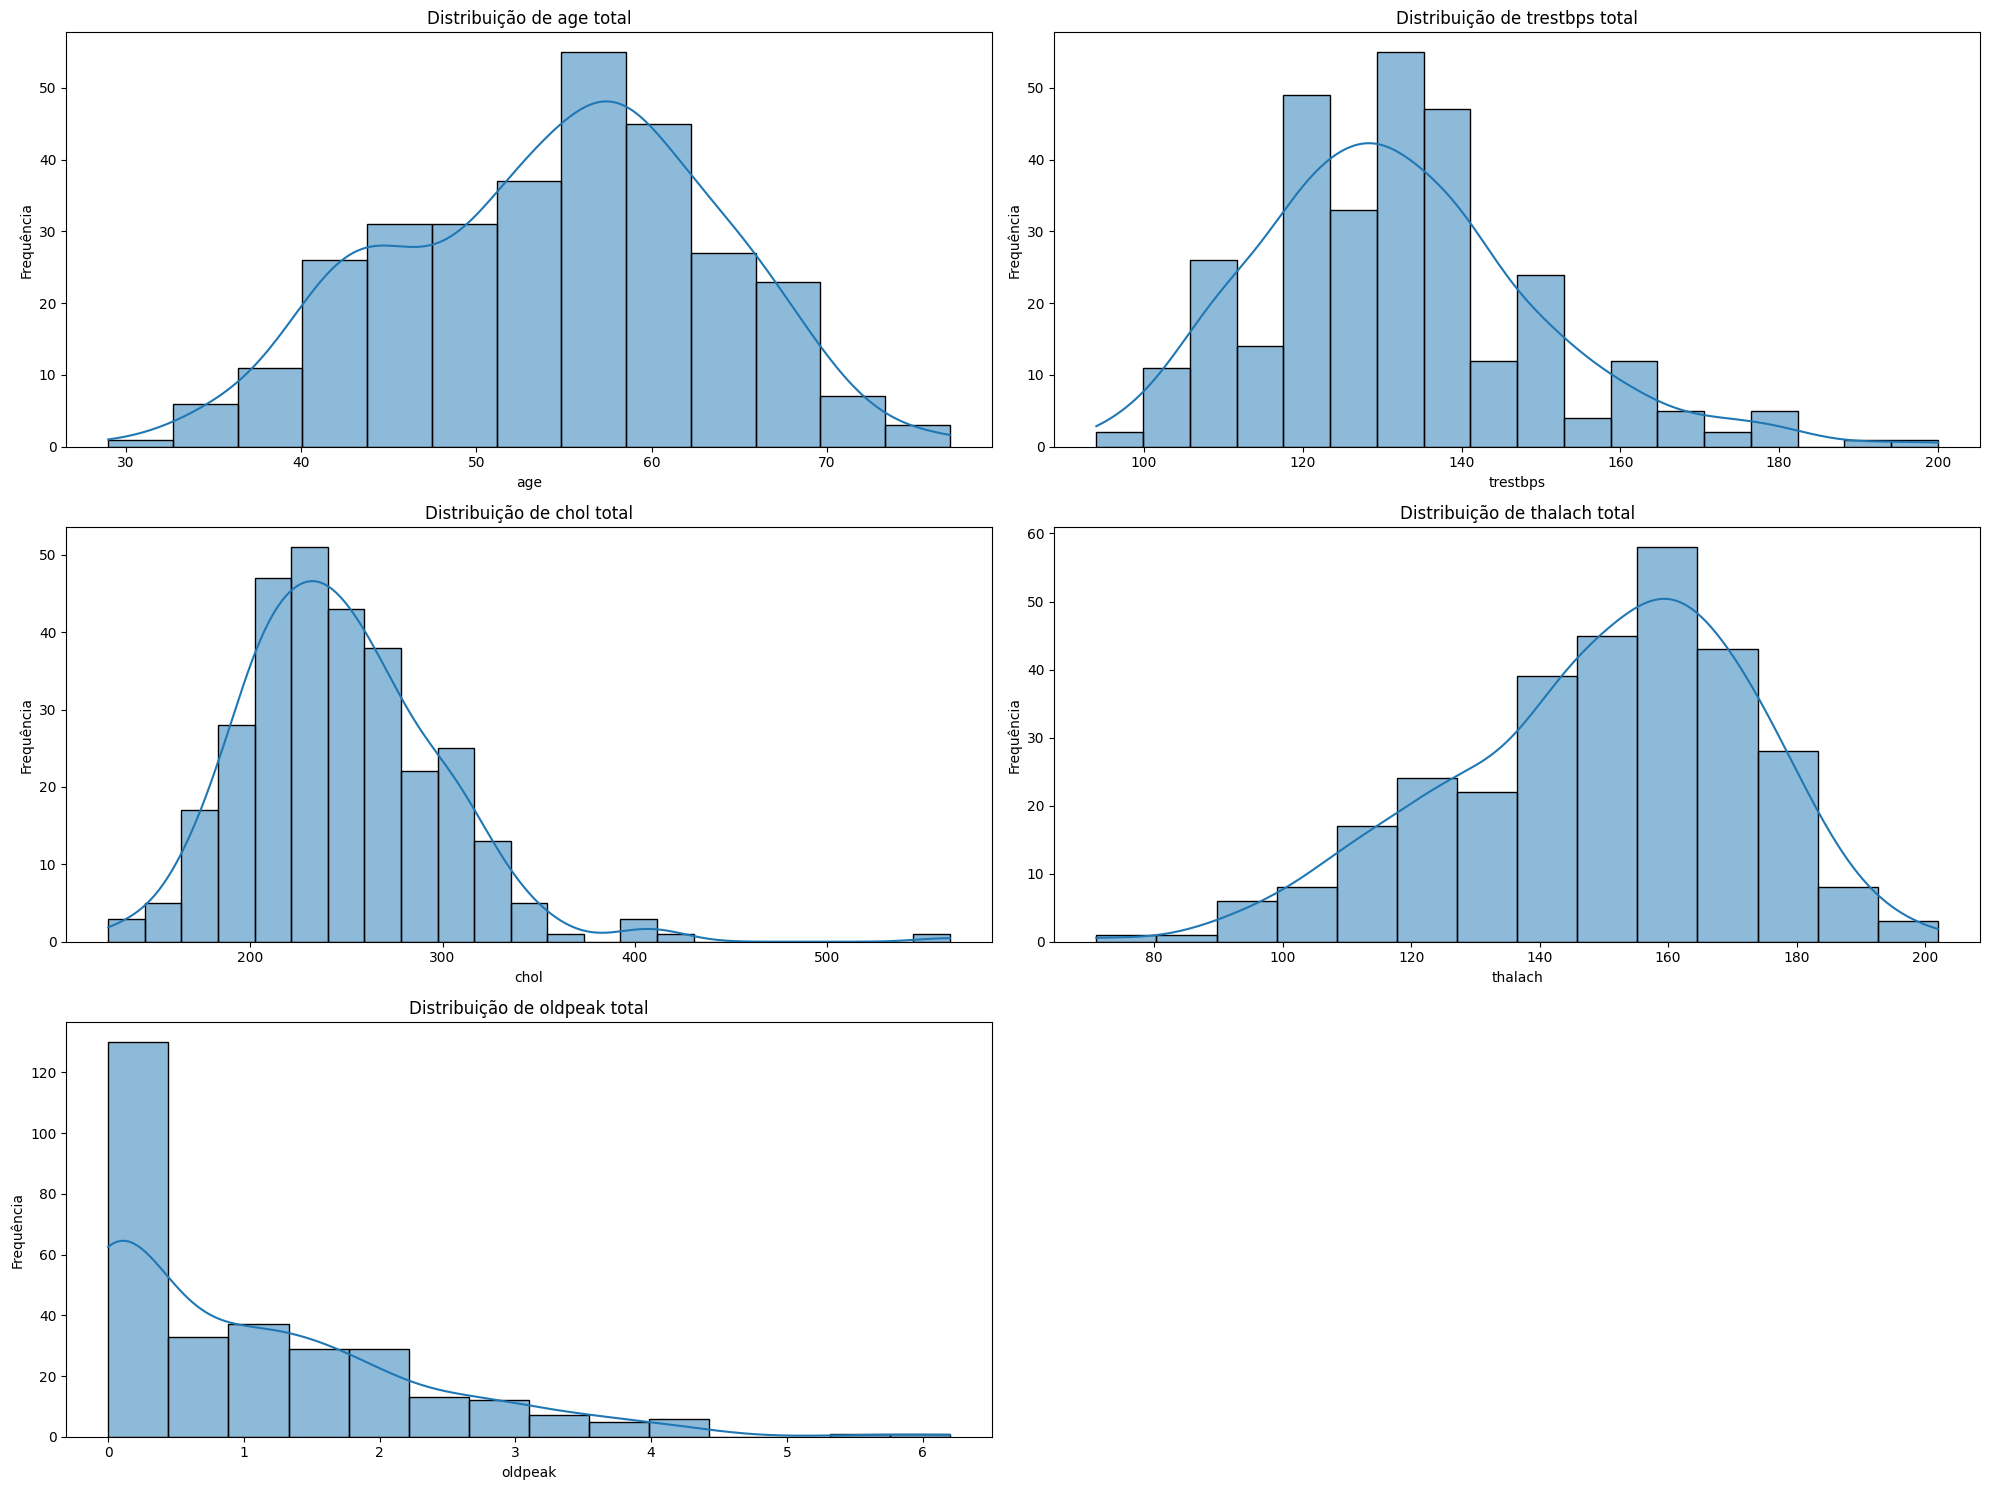

In [32]:
plt.figure(figsize=(20, 15))

# Plotando cada atributo em subplots
for i, column in enumerate(quantitative_features, 1):
    plt.subplot(3, 2, i)
    sns.histplot(data=X_y, x=column, kde=True, multiple='stack')
    plt.title(f'Distribuição de {column} total')
    plt.xlabel(column)
    plt.ylabel('Frequência')

plt.tight_layout()
plt.show()

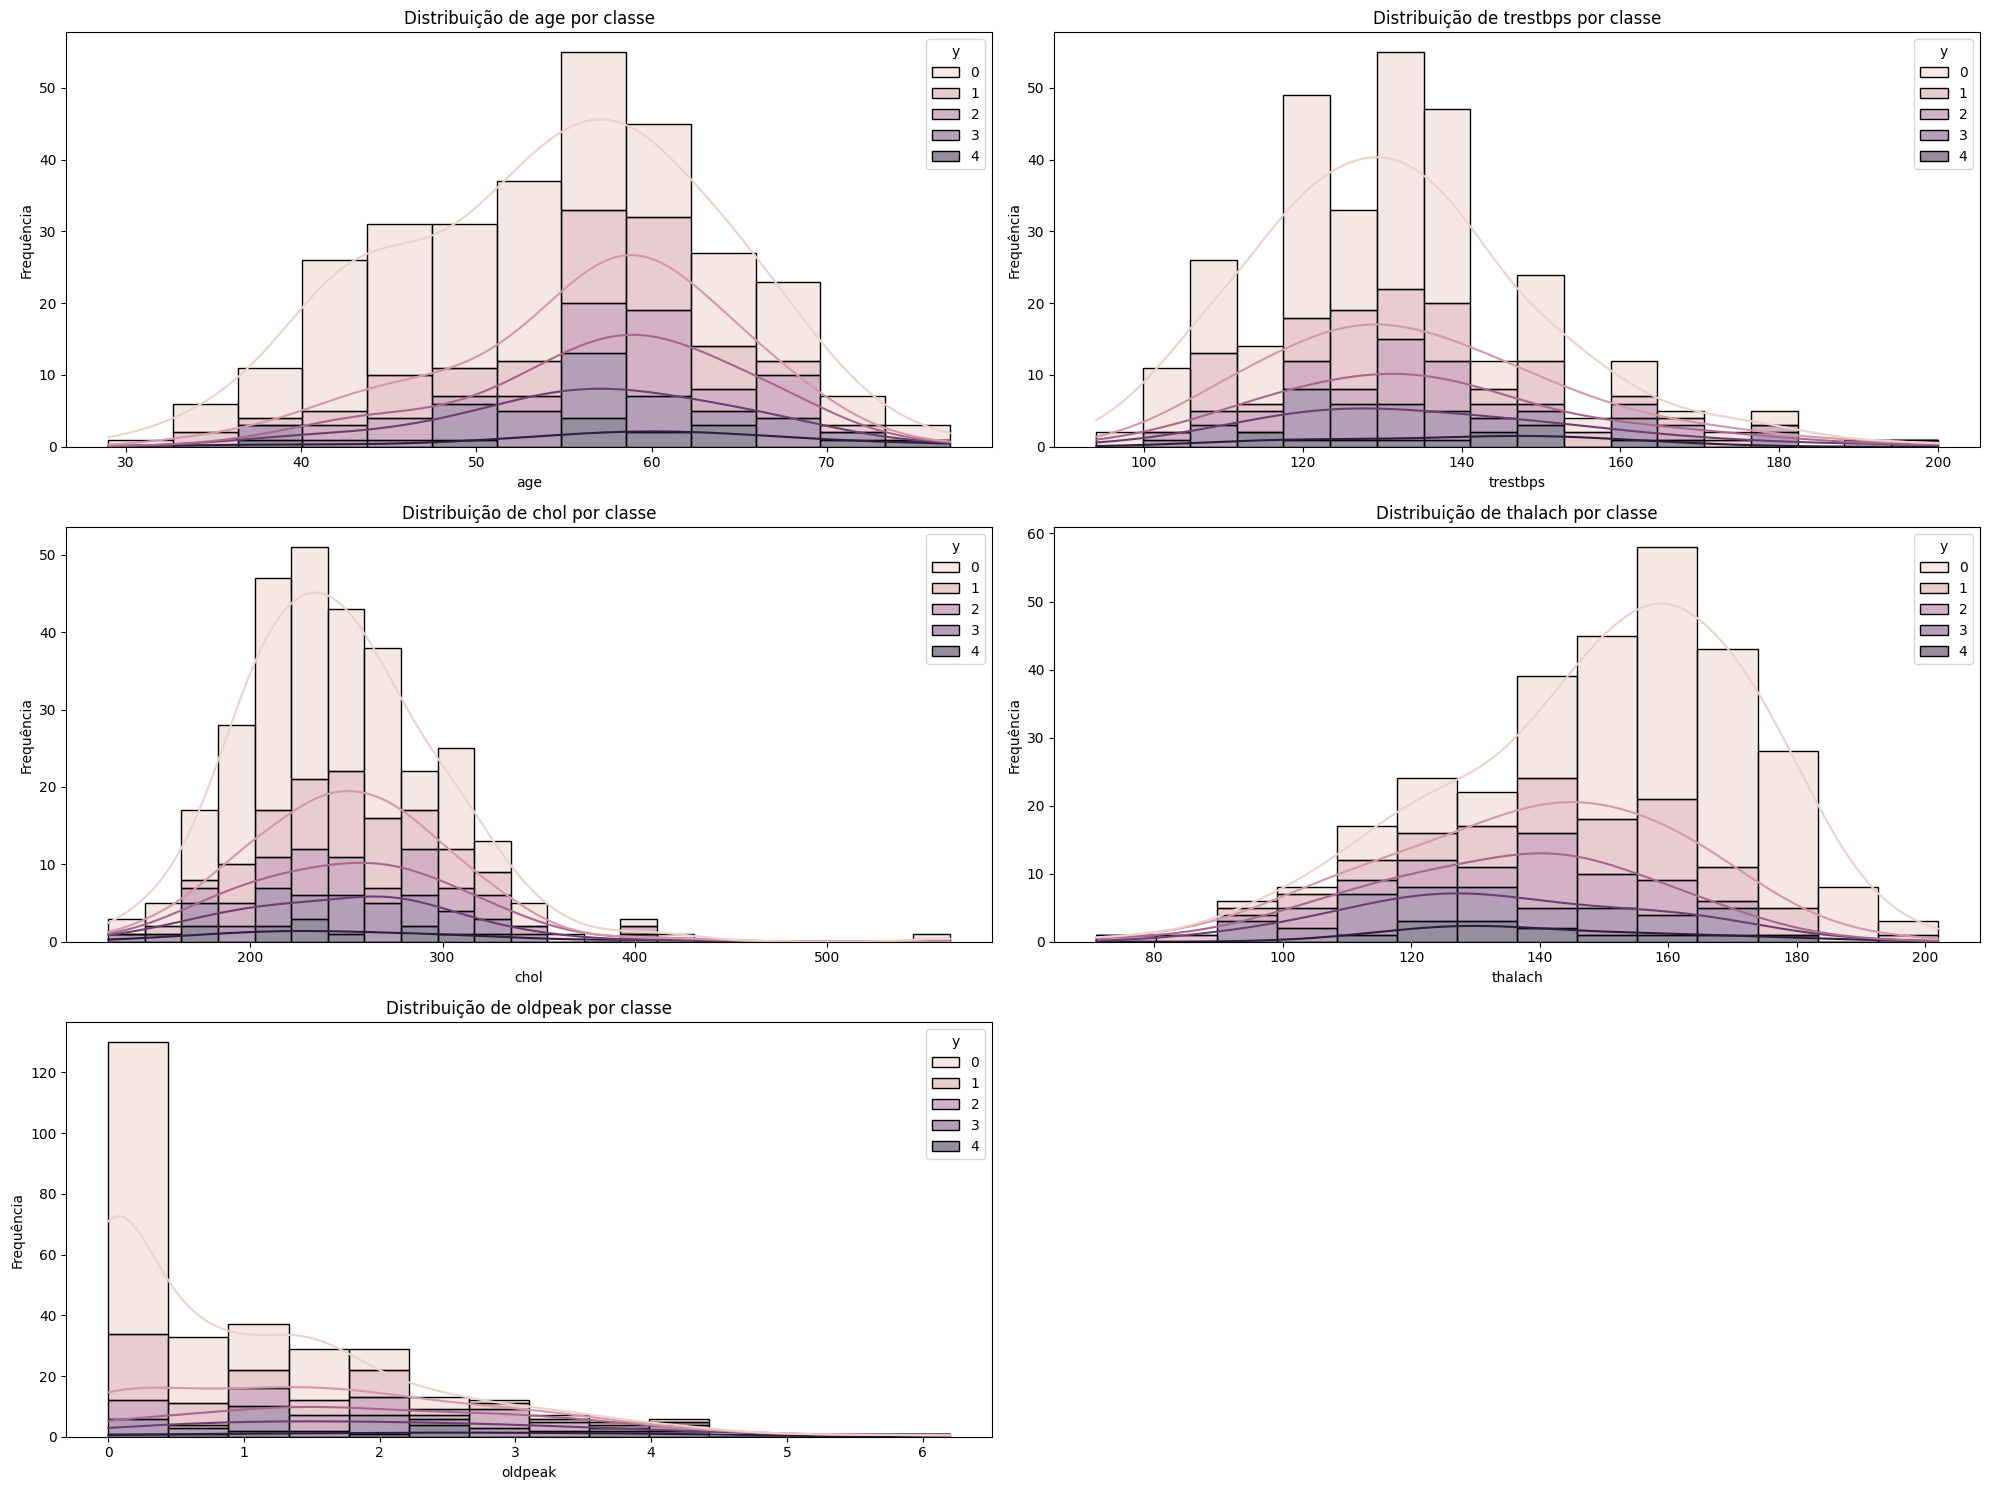

In [33]:
plt.figure(figsize=(20, 15))

# Plotando cada atributo em subplots
for i, column in enumerate(quantitative_features, 1):
    plt.subplot(3, 2, i)
    sns.histplot(data=X_y, x=column, hue='y', kde=True, multiple='stack')
    plt.title(f'Distribuição de {column} por classe')
    plt.xlabel(column)
    plt.ylabel('Frequência')

plt.tight_layout()
plt.show()

- **Age (Idade):**
    
    A idade apresenta uma distribuição próxima da normal, com um leve viés para a direita. A maioria das classes de doença cardíaca apresenta picos em faixas etárias semelhantes, mas é possível notar uma leve concentração de casos com maior gravidade em faixas etárias mais avançadas.

- **Trestbps (Pressão Arterial em Repouso):**

    A pressão arterial em repouso parece ter uma distribuição levemente assimétrica à direita.
    
    As classes são relativamente sobrepostas, mas a classe 0 (sem doença) tem valores ligeiramente mais baixos em média.

- **Chol (Colesterol):**
    
    O colesterol tem uma distribuição ampla, com uma cauda à direita, indicando alguns casos com níveis de colesterol muito altos.
    
    Não há uma diferença clara nas distribuições entre as classes, sugerindo que o colesterol elevado pode estar presente independentemente da gravidade da doença.

- **Thalach (Frequência Cardíaca Máxima):**

    As classes de maior gravidade de doença cardíaca parecem ser a 0 parecem ter valores mais baixos de frequência cardíaca máxima, o que pode indicar um comprometimento na capacidade cardiovascular.

- **Oldpeak (Depressão do Segmento ST):**
    
    A distribuição de oldpeak é altamente assimétrica, com a maioria dos valores próximos de zero.
    
    As classes de maior gravidade apresentam valores maiores de oldpeak, indicando um nível maior de depressão do segmento ST, um indicativo potencial de isquemia.

### h) Transformações

Antes de aplicar PCA ou qualquer algoritmo de ML, é importante escalar os dados, especialmente considerando que os atributos têm escalas diferentes. Vamos usar o StandardScaler do sklearn para deixar nossos dados quantitativos com média zero e desvio padrão um. Esse tipo de transformação também é preferida quando os dados apresentam proximidade a uma distribuição normal:

$$
z = \frac{x−μ}{σ}
$$


In [34]:
X.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6.0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3.0
2,67,1,4,120,229,0,2,129,1,2.6,2,2,7.0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3.0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3.0


In [35]:
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[quantitative_features] = scaler.fit_transform(X[quantitative_features])

In [36]:
X_scaled.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,0.948726,1,1,0.757525,-0.264900,1,2,0.017197,0,1.087338,3,0,6.0
1,1.392002,1,4,1.611220,0.760415,0,2,-1.821905,1,0.397182,2,3,3.0
2,1.392002,1,4,-0.665300,-0.342283,0,2,-0.902354,1,1.346147,2,2,7.0
3,-1.932564,1,3,-0.096170,0.063974,0,0,1.637359,0,2.122573,3,0,3.0
4,-1.489288,0,2,-0.096170,-0.825922,0,2,0.980537,0,0.310912,1,0,3.0


### i) Análise de Componentes Principais (PCA)

A Análise de Componentes Principais (PCA) é uma técnica estatística utilizada para reduzir a dimensionalidade de conjuntos de dados, mantendo o máximo de variância possível. Essa técnica é especialmente útil em cenários onde se tem um grande número de variáveis (atributos) que podem ser interdependentes.

O principal objetivo do PCA é transformar um conjunto de variáveis originais em um novo conjunto de variáveis, chamadas de componentes principais. Esses componentes principais são combinações lineares das variáveis originais e são ordenados de forma que o primeiro componente principal capture a maior parte da variância dos dados, o segundo componente captura a segunda maior parte da variância, e assim por diante.

#### Etapas do PCA

1. **Centralização dos Dados**: Primeiro, as médias das variáveis são subtraídas para centralizar os dados em torno da origem (média zero).

2. **Cálculo da Matriz de Covariância**: A matriz de covariância é calculada para entender como as variáveis se relacionam entre si. A matriz de covariância mostra a variância das variáveis em relação umas às outras.

3. **Cálculo dos Valores e Vetores Próprios**: Os valores próprios (autovalores) e os vetores próprios (autovetores) da matriz de covariância são calculados. Os autovalores indicam a quantidade de variância que cada componente principal captura, enquanto os autovetores representam a direção dos novos componentes no espaço de atributos.

4. **Seleção dos Componentes Principais**: Os componentes principais são selecionados com base nos autovalores, e normalmente, os componentes com os maiores autovalores são escolhidos, pois eles representam a maior parte da variância dos dados.

5. **Projeção dos Dados**: Finalmente, os dados originais são projetados nos novos componentes principais selecionados. Isso resulta em um novo conjunto de dados com uma dimensionalidade reduzida.

In [37]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2', 'PC3'])
pca_df['y'] = y.reset_index(drop=True)

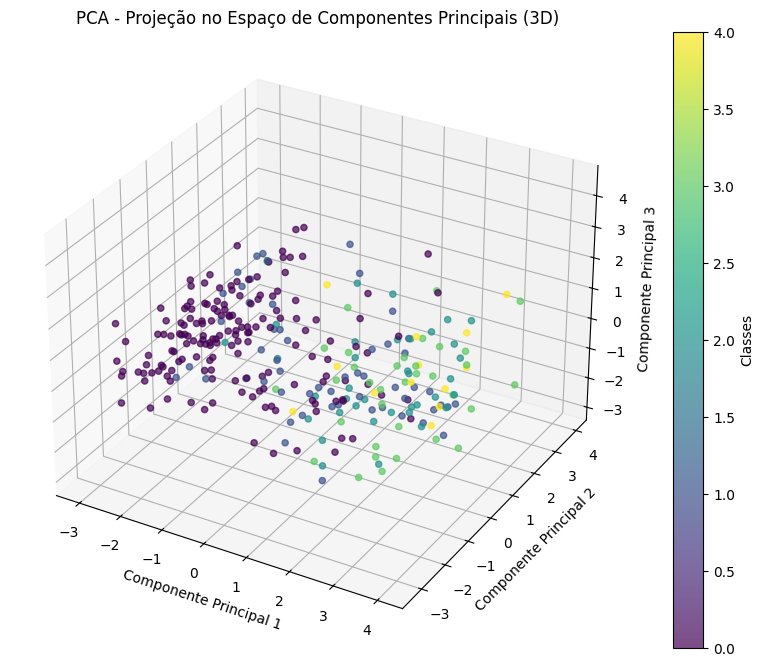

In [38]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], c=pca_df['y'], cmap='viridis', alpha=0.7)

ax.set_title('PCA - Projeção no Espaço de Componentes Principais (3D)')
ax.set_xlabel('Componente Principal 1')
ax.set_ylabel('Componente Principal 2')
ax.set_zlabel('Componente Principal 3')

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Classes')

plt.show()


In [40]:
fig = px.scatter_3d(
    pca_df, 
    x='PC1', 
    y='PC2', 
    z='PC3', 
    color='y',
    color_continuous_scale='Viridis'
)

fig.update_traces(marker=dict(size=3))

fig.update_layout(
    scene=dict(
        xaxis_title='Componente Principal 1',
        yaxis_title='Componente Principal 2',
        zaxis_title='Componente Principal 3'
    )
)

fig.show()

A classe 0 apresentou se distinguir mais das demais, apesar de ter alguns pontos ainda próximos das outras classes. As classes de doenças cardíacas estão separadas em sua maioria das saudáveis, porém foca difícil distinguir dentre cada uma pelo plot.